
<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Voting Ensemble : Multiple Approaches </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px"> Index of Contents</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
 <div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Approach 1 : Voting Ensemble of Random Forest, XGB & CatBoost.<br><br>
📌
Approach 2 : Modified Approach 1 as per insights fetched from @AmbrosM in the <a href="https://www.kaggle.com/competitions/playground-series-s3e20/discussion/432294"> Discussion </a>
      </div>

 <div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Approach 1 : Voting Ensemble of Random Forest, XGB & CatBoost. </div>

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
0. Data Loading and Preprocessing<br> </div>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data
train_path = "/kaggle/input/playground-series-s3e20/train.csv"
test_path = "/kaggle/input/playground-series-s3e20/test.csv"


In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [4]:
# Split the data into features and target
X = train_data.drop(['ID_LAT_LON_YEAR_WEEK', 'emission'], axis=1)
y = train_data['emission']


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
1. Data Splitting<br> </div>

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


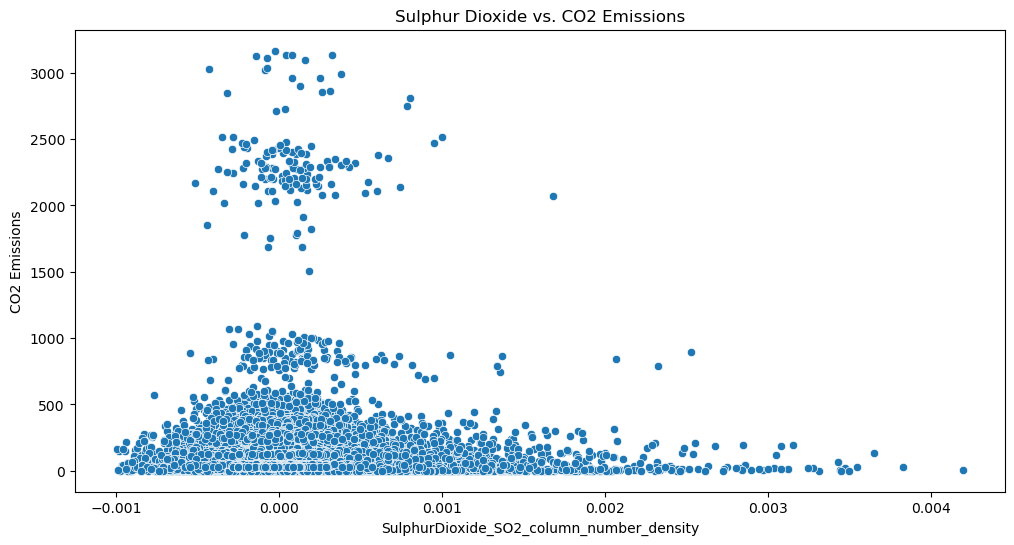

In [6]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='SulphurDioxide_SO2_column_number_density', y='emission', data=train_data)
plt.title('Sulphur Dioxide vs. CO2 Emissions')
plt.xlabel('SulphurDioxide_SO2_column_number_density')
plt.ylabel('CO2 Emissions')
plt.show()


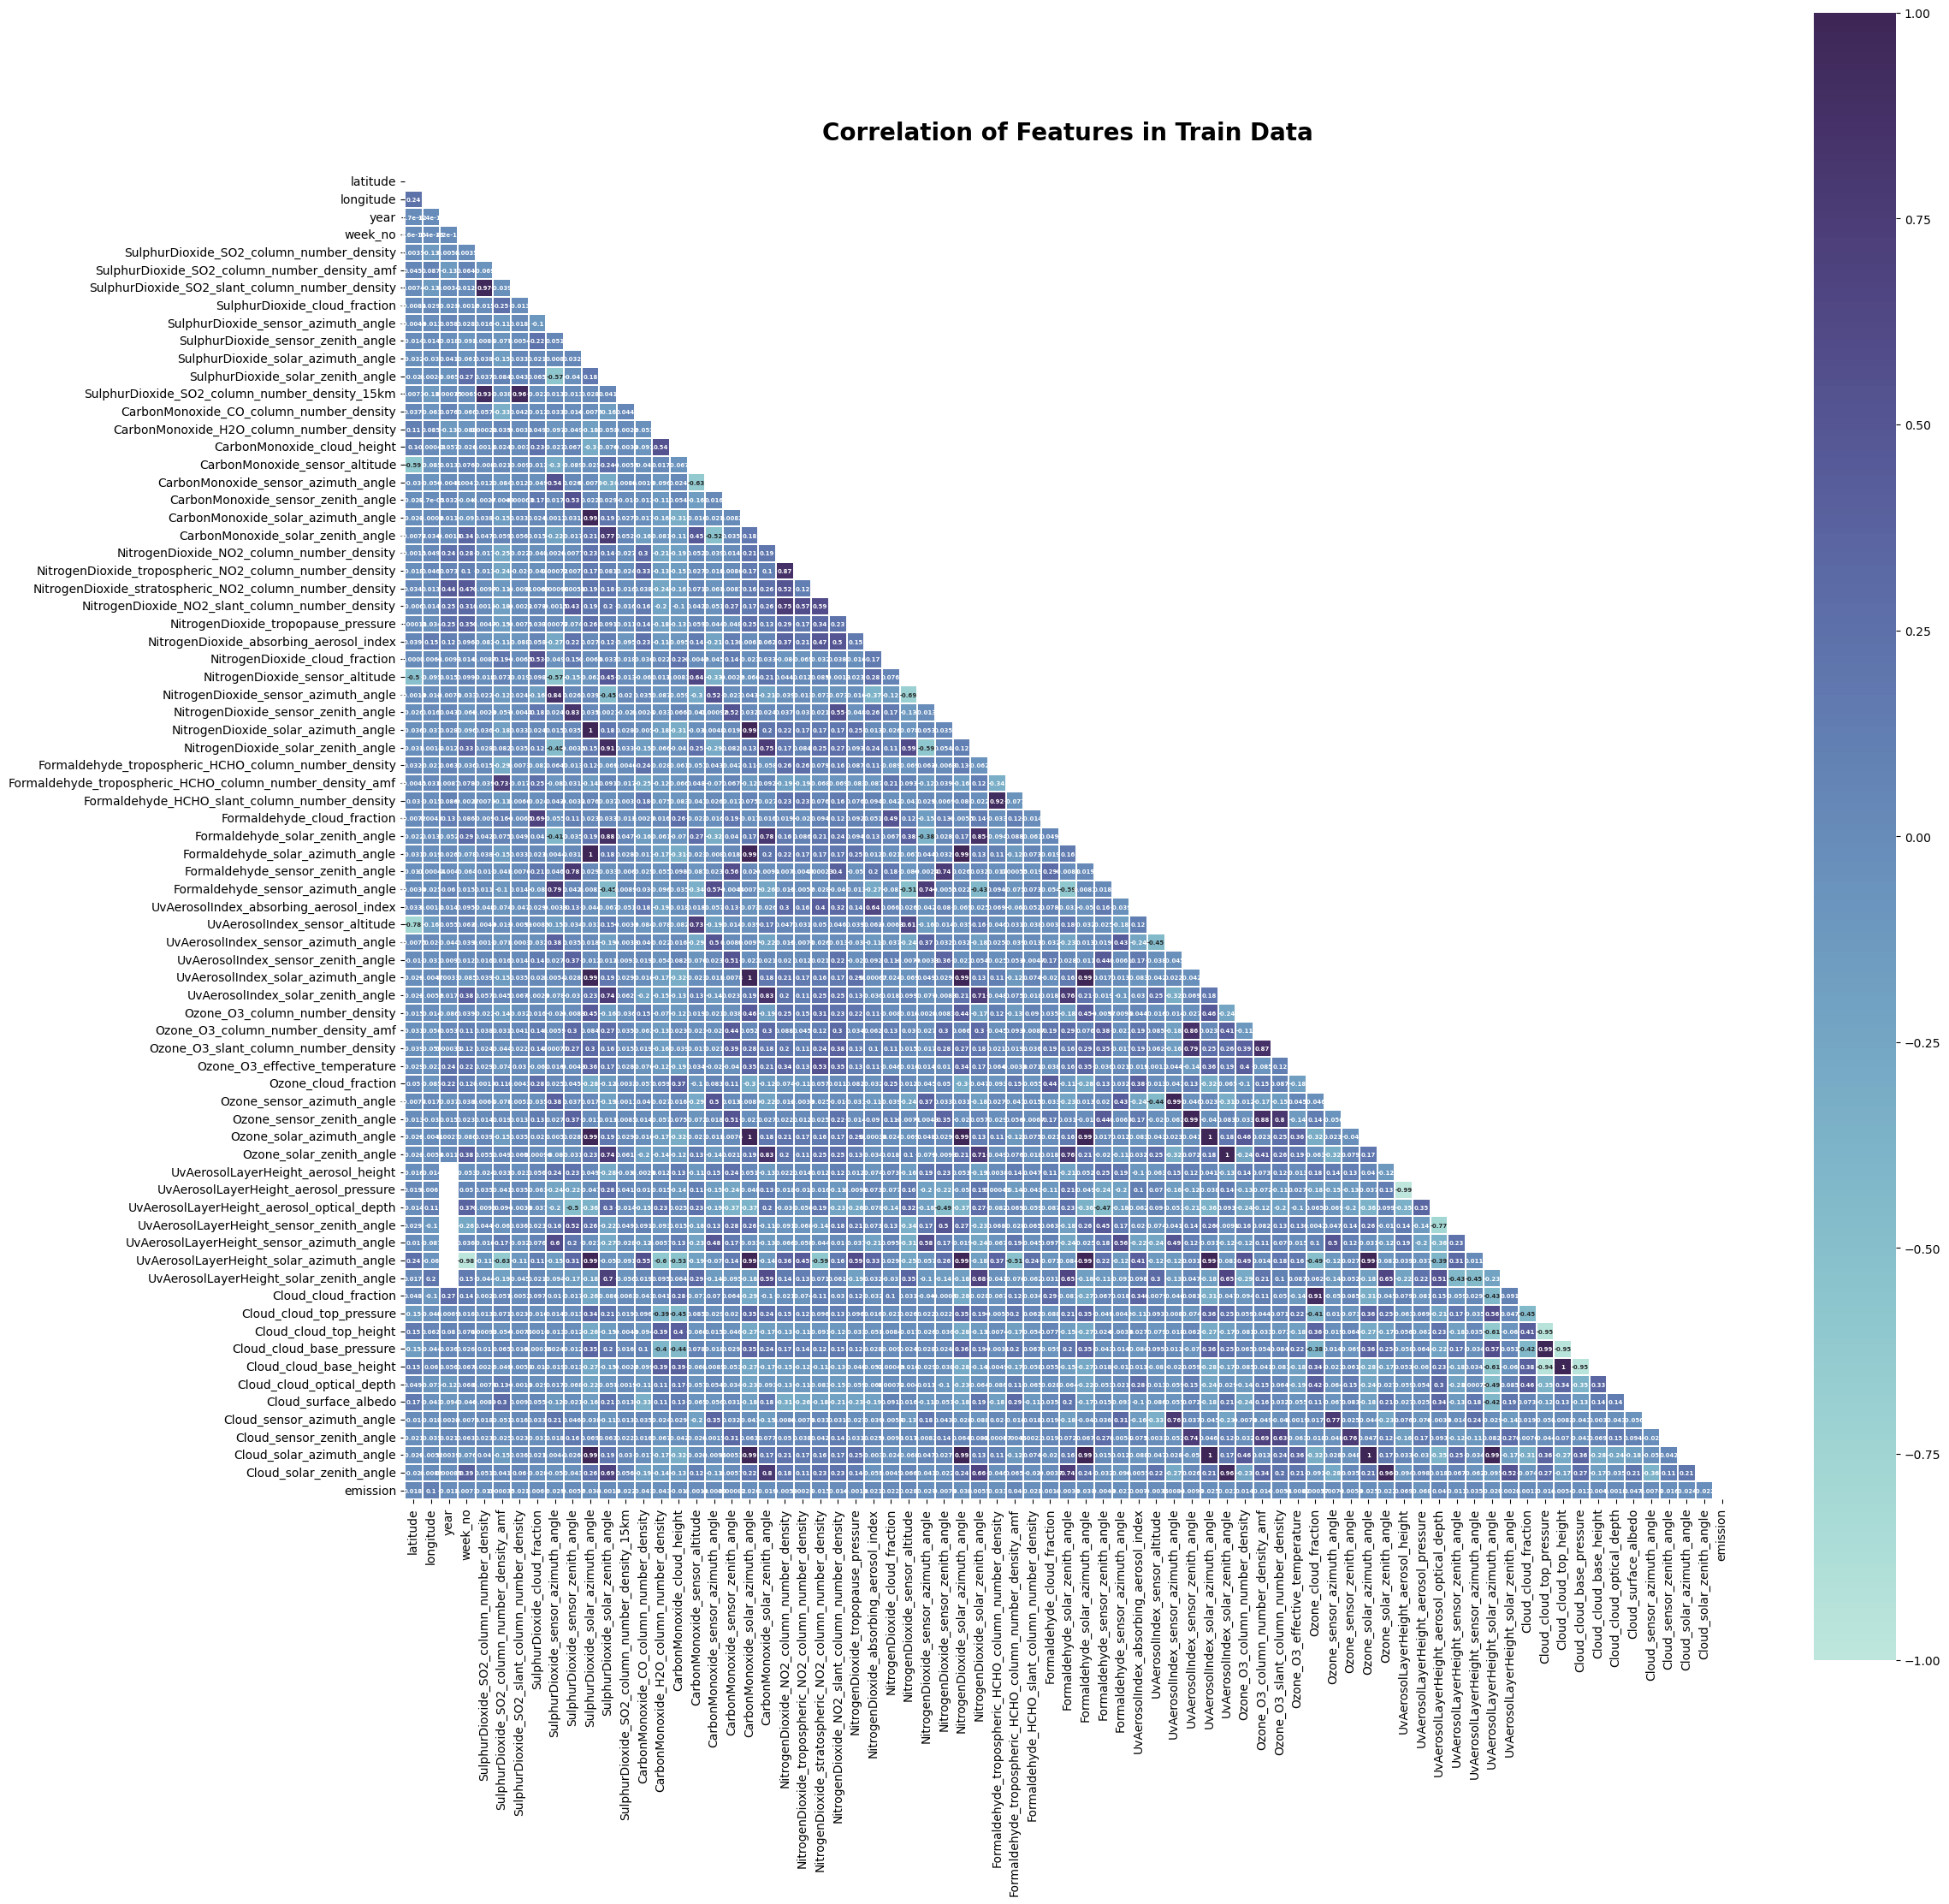

In [7]:
def plot_heatmap(df, title):
    # Create a mask for the top half of the matrix
    mask = np.triu(np.ones_like(df.corr()))

    # Set the colormap and figure size
    colormap = sns.cubehelix_palette(n_colors=15, start=.46, rot=-.45, dark=.2, hue=0.95, as_cmap=True)
    plt.figure(figsize=(25, 25))

    # Set the title and font properties
    plt.title(f'Correlation of Features in {title}', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked upper triangle
    sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 5, "weight": "bold"},
                mask=mask)

# Call the plot_heatmap function
plot_heatmap(train_data.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1), title='Train Data')


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
3. Defining objective for optuna based hyperparameter tuning<br> </div>

In [8]:
# Define the Optuna objective function
def objective(trial):
    # Hyperparameters for RandomForestRegressor
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 3, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
    
    # Hyperparameters for XGBRegressor
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 20)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.001, 0.3)
    xgb_subsample = trial.suggest_float('xgb_subsample', 0.5, 1.0)
    
    # Hyperparameters for CatBoostRegressor
    catboost_iterations = trial.suggest_int('catboost_iterations', 50, 300)
    catboost_depth = trial.suggest_int('catboost_depth', 3, 15)
    catboost_learning_rate = trial.suggest_float('catboost_learning_rate', 0.001, 0.3)
    
    # Initialize the individual regressors
    rf_regressor = RandomForestRegressor(n_estimators=rf_n_estimators, max_depth=rf_max_depth,
                                         min_samples_split=rf_min_samples_split, random_state=42, n_jobs=-1)
    xgb_regressor = XGBRegressor(n_estimators=xgb_n_estimators, max_depth=xgb_max_depth,
                                 learning_rate=xgb_learning_rate, subsample=xgb_subsample, random_state=42)
    catboost_regressor = CatBoostRegressor(iterations=catboost_iterations, depth=catboost_depth,
                                           learning_rate=catboost_learning_rate, random_state=42, verbose=0)
    
    # Impute missing values using SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    
    # Train the individual regressors on the imputed data
    rf_regressor.fit(X_train_imputed, y_train)
    xgb_regressor.fit(X_train_imputed, y_train)
    catboost_regressor.fit(X_train_imputed, y_train)
    
    # Initialize the VotingRegressor with individual regressors
    voting_regressor = VotingRegressor(estimators=[
        ('rf', rf_regressor),
        ('xgb', xgb_regressor),
        ('catboost', catboost_regressor),
    ])
    
    # Train the VotingRegressor on the imputed data
    voting_regressor.fit(X_train_imputed, y_train)
    
    # Predict on the validation set using the VotingRegressor
    voting_pred = voting_regressor.predict(X_val_imputed)
    
    # Calculate RMSE on the validation set for the VotingRegressor
    rmse_voting = mean_squared_error(y_val, voting_pred, squared=False)
    
    return rmse_voting


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
4. Hyperparameter tuning<br> </div>

In [9]:
##Already done in previous versions
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=12,n_jobs=4, show_progress_bar=True)

#best_params = study.best_params


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
5. Individual regressor fitting<br> </div>

In [10]:
##Already done in previous versions

# best_rf_regressor = RandomForestRegressor(n_estimators=best_params['rf_n_estimators'], random_state=42)
# best_xgb_regressor = XGBRegressor(n_estimators=best_params['xgb_n_estimators'], random_state=42)
# best_catboost_regressor = CatBoostRegressor(iterations=best_params['catboost_iterations'], random_state=42, verbose=0)


Initializing with values obtained after dense optuna based hyperparam optimization in version 11 - https://www.kaggle.com/code/suraj520/optuna-voting-ensemble-rf-xgb-catboost

In [11]:
# Initialize the best regressors with the obtained parameters
best_rf_regressor = RandomForestRegressor(
    n_estimators=295, max_depth=18, min_samples_split=13, random_state=42
)
best_xgb_regressor = XGBRegressor(
    n_estimators=202,
    max_depth=16,
    learning_rate=0.06675254007570432,
    subsample=0.6288299771275165,
    random_state=42
)
best_catboost_regressor = CatBoostRegressor(
    iterations=83,
    depth=12,
    learning_rate=0.18459455702487776,
    random_state=42,
    verbose=0
)

In [12]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)


In [13]:
best_rf_regressor.fit(X_train_imputed[:100], y_train[:100]) #for faster convergence in this version,we're fitting with 100 samples.. Entire fit is done in prev. versions
best_xgb_regressor.fit(X_train_imputed[:100], y_train[:100])
best_catboost_regressor.fit(X_train_imputed[:100], y_train[:100])


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
6. Soft voting ensemble<br> </div>

In [14]:
voting_regressor = VotingRegressor(estimators=[
    ('rf', best_rf_regressor),
    ('xgb', best_xgb_regressor),
    ('catboost', best_catboost_regressor),
])

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
7. Voting regressor predictions<br> </div>

In [15]:
voting_regressor.fit(X_train_imputed[:100], y_train[:100])
voting_pred = voting_regressor.predict(X_val_imputed)


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
8. Evaluation: RMSE Calculation<br> </div>

In [16]:
rmse_rf = mean_squared_error(y_val, best_rf_regressor.predict(X_val_imputed), squared=False)
rmse_xgb = mean_squared_error(y_val, best_xgb_regressor.predict(X_val_imputed), squared=False)
rmse_catboost = mean_squared_error(y_val, best_catboost_regressor.predict(X_val_imputed), squared=False)
rmse_voting = mean_squared_error(y_val, voting_pred, squared=False)


In [17]:
print(f'RF RMSE: {rmse_rf}')
print(f'XGB RMSE: {rmse_xgb}')
print(f'CatBoost RMSE: {rmse_catboost}')
print(f'Voting RMSE: {rmse_voting}')


RF RMSE: 133.5578166627525
XGB RMSE: 135.53038182729756
CatBoost RMSE: 129.41532527625944
Voting RMSE: 131.06613742184592


 <div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 The RMSE is very high since we fitted the model in this approach on 100 samples only, Refer previous versions(version 11) where Approach 1 has been done in detailed manner.

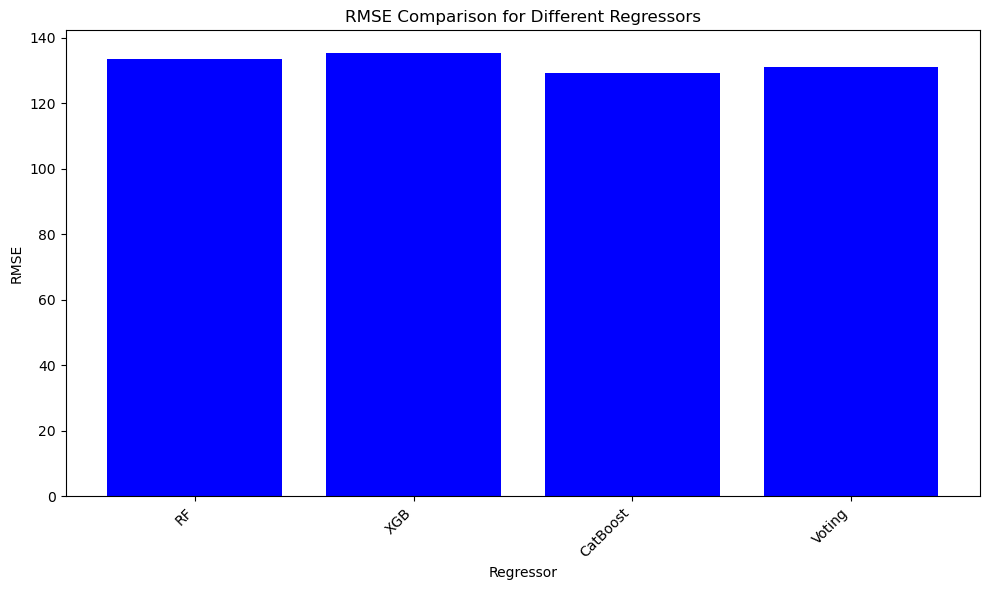

In [18]:
import matplotlib.pyplot as plt
rmse_values = [rmse_rf, rmse_xgb, rmse_catboost, rmse_voting]
model_names = ['RF', 'XGB', 'CatBoost', 'Voting']
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Regressor')
plt.ylabel('RMSE')
plt.title('RMSE Comparison for Different Regressors')
plt.tight_layout()
plt.show()


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
📌
9. Test set prediction and submission<br> </div>

In [19]:
imputer = SimpleImputer(strategy='mean')
test_features = imputer.fit_transform(test_data.drop('ID_LAT_LON_YEAR_WEEK', axis=1))



In [20]:
test_rf_predictions = best_rf_regressor.predict(test_features)
test_xgb_predictions = best_xgb_regressor.predict(test_features)
test_catboost_predictions = best_catboost_regressor.predict(test_features)


In [21]:
test_predictions = voting_regressor.predict(test_features)


In [22]:
submission = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test_data['ID_LAT_LON_YEAR_WEEK'],
    'emission': test_predictions
})
submission.to_csv('submission.csv', index=False)

In [23]:
submission

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,92.759697
1,ID_-0.510_29.290_2022_01,136.284912
2,ID_-0.510_29.290_2022_02,57.874169
3,ID_-0.510_29.290_2022_03,91.335263
4,ID_-0.510_29.290_2022_04,61.731323
...,...,...
24348,ID_-3.299_30.301_2022_44,87.553598
24349,ID_-3.299_30.301_2022_45,120.443702
24350,ID_-3.299_30.301_2022_46,63.461476
24351,ID_-3.299_30.301_2022_47,85.268388


 <div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Approach 2 via insights from <a href="https://www.kaggle.com/competitions/playground-series-s3e20/discussion/432294"> Discussion </a>

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
    📌 <b>1. Addressing Satellite Measurements and Location Data:</b><br>
Since the satellite measurements are considered to be noisy and unrelated to the target, we will focus on using only the four features: latitude, longitude, year, and week_no. Additionally, we'll convert latitude and longitude into meaningful categorical features using a clustering approach. Let's use K-Means clustering to create location clusters.</div>




In [24]:
from sklearn.cluster import KMeans

# Combine latitude and longitude into a single feature
X['location'] = X[['latitude', 'longitude']].apply(lambda x: f"{x[0]:.3f}_{x[1]:.3f}", axis=1)




In [25]:
X

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,location
0,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,-0.510_29.290
1,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,-0.510_29.290
2,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,-0.510_29.290
3,-0.510,29.290,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,-0.510_29.290
4,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,-0.510_29.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,5459.185355,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,-3.299_30.301
79019,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,5606.449457,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,-3.299_30.301
79020,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,...,6222.646776,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,-3.299_30.301
79021,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,32.599393,...,7896.456885,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,-3.299_30.301


In [26]:
# Perform K-Means clustering on the combined location feature
num_clusters = 50  # You can adjust this based on experimentation
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
X['location_cluster'] = kmeans.fit_predict(X[['latitude', 'longitude']])

# Drop unnecessary columns
X = X.drop(['latitude', 'longitude'], axis=1)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
X

,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,location,location_cluster
0,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,...,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,-0.510_29.290,10
1,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,...,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,-0.510_29.290,10
2,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,-150.191757,23.206415,...,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,-0.510_29.290,10
3,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,-0.510_29.290,10
4,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,-137.409159,24.331972,...,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,-0.510_29.290,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,-140.821274,25.148563,...,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,-3.299_30.301,31
79019,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,-131.114411,31.197638,...,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,-3.299_30.301,31
79020,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,-3.299_30.301,31
79021,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,32.599393,-129.573396,33.906037,...,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,-3.299_30.301,31


In [28]:
#splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Perform the same clustering on the test data
test_data['location'] = test_data[['latitude', 'longitude']].apply(lambda x: f"{x[0]:.3f}_{x[1]:.3f}", axis=1)
test_data['location_cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
test_features = test_data.drop('ID_LAT_LON_YEAR_WEEK', axis=1)

<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
    📌 <b> 2. Handling Lockdown and Temporal Variations:</b><br>

To address the issues related to the lockdown and temporal variations, we'll consider the year 2021 as the most relevant for predicting the target year 2022. We will use the emission levels of 2021 as the basis for predicting emissions in 2022.</div>

In [30]:
# Filter data for the year 2021 for training
X_train_filtered = X_train[X_train['year'] == 2021]
y_train_filtered = y_train[X_train['year'] == 2021]

X_val_filtered = X_val[X_val['year'] == 2021]
y_val_filtered = y_val[X_val['year'] == 2021]



In [31]:
#dropping location
X_train_filtered = X_train_filtered.drop(['location'],axis=1)
X_val_filtered = X_val_filtered.drop(['location'],axis=1)

In [32]:
# Impute missing values using SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_filtered)
X_val_imputed = imputer.fit_transform(X_val_filtered)

In [33]:
# Train best models via hyperparams previously tuned in version 11
best_rf_regressor.fit(X_train_imputed, y_train_filtered)
best_xgb_regressor.fit(X_train_imputed, y_train_filtered)
best_catboost_regressor.fit(X_train_imputed, y_train_filtered)


In [34]:
voting_regressor = VotingRegressor(estimators=[
    ('rf', best_rf_regressor),
    ('xgb', best_xgb_regressor),
    ('catboost', best_catboost_regressor),
])
voting_regressor.fit(X_train_imputed, y_train_filtered)


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=18,
                                                   min_samples_split=13,
                                                   n_estimators=295,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=...
                                          learning_rate=0.06675254007570432,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=16,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=202, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x786d26c9ae60>)])

In [35]:
#dropping redundant columns
test_features = test_features.drop(['latitude', 'longitude','location'], axis=1)
test_features


,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,location_cluster
0,2022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583,10
1,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,28.896124,...,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380,10
2,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,30.054682,...,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361,10
3,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,58.862543,-152.999440,21.806625,...,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774,10
4,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,15.646016,-135.794754,24.328299,...,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24348,2022,44,-0.000618,0.745549,-0.000461,0.234492,72.306198,61.114494,-123.965439,19.866062,...,6260.120033,55483.459980,5260.120056,30.398508,0.180046,-25.528588,45.284576,-116.521412,29.992562,31
24349,2022,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6678.843299,53589.917383,5678.951521,19.223844,0.177833,-13.380005,43.770351,-122.405759,29.017975,31
24350,2022,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5336.282475,62646.761340,4336.282491,13.801194,0.219471,-5.072065,33.226455,-124.530639,30.187472,31
24351,2022,47,0.000071,1.003805,0.000077,0.205077,74.327427,38.215228,-131.809054,26.745795,...,7188.578533,50728.313991,6188.578464,27.887489,0.247275,-0.668714,45.885617,-129.006797,30.427455,31


In [36]:
#impute missing values
test_features_imputed = imputer.fit_transform(test_features)


In [37]:
# Predict using the trained models
test_rf_predictions = best_rf_regressor.predict(test_features_imputed)
test_xgb_predictions = best_xgb_regressor.predict(test_features_imputed)
test_catboost_predictions = best_catboost_regressor.predict(test_features_imputed)

# Combine predictions using the VotingRegressor (if you prefer using a single model)
test_predictions = voting_regressor.predict(test_features_imputed)

# Print or use the predictions as needed
print("Random Forest Predictions:", test_rf_predictions)
print("XGBoost Predictions:", test_xgb_predictions)
print("CatBoost Predictions:", test_catboost_predictions)
print("Voting Regressor Predictions:", test_predictions)


Random Forest Predictions: [20.50317961 22.13215196 22.75132759 ... 81.39712307 99.40095943
 99.27714937]
XGBoost Predictions: [129.54442    8.451912  36.498486 ... 108.2349   122.38693  143.07747 ]
CatBoost Predictions: [100.30111362  27.13207838  13.42275415 ...  67.15343651 157.09799252
  86.10325136]
Voting Regressor Predictions: [ 83.44957052  19.23871409  24.2241891  ...  85.59515367 126.29529477
 109.48595653]


<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Arial; padding:10px; border: 5px solid #19180F; border-radius:10px">
    📌
<b>3. Generating the Submission File:</b><br>

Use the predicted emissions to generate the submission file.</div>

In [38]:
submission = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test_data['ID_LAT_LON_YEAR_WEEK'],
    'emission': test_predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


In [39]:
submission

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,83.449571
1,ID_-0.510_29.290_2022_01,19.238714
2,ID_-0.510_29.290_2022_02,24.224189
3,ID_-0.510_29.290_2022_03,19.719318
4,ID_-0.510_29.290_2022_04,22.926490
...,...,...
24348,ID_-3.299_30.301_2022_44,138.625978
24349,ID_-3.299_30.301_2022_45,129.731582
24350,ID_-3.299_30.301_2022_46,85.595154
24351,ID_-3.299_30.301_2022_47,126.295295
